In [1]:
# Source : https://noureldinalaa.github.io/capsuleNetwork/
# Pas tout a été copié
# import resources
import numpy as np
import torch

# random seed (for reproducibility)
seed = 1
# set random seed for numpy
np.random.seed(seed)
# set random seed for pytorch
torch.manual_seed(seed)

In [2]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

# Revenir au dossier parent et définir le chemin vers le dataset
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
dataset_dir = os.path.join(parent_dir, "dataset","archive", "BBBC005_v1_ground_truth", "BBBC005_v1_ground_truth")

# Vérifier si le dossier existe
if not os.path.exists(dataset_dir):
    raise ValueError(f"Le dossier {dataset_dir} n'existe pas. Vérifiez le chemin.")

# Obtenir tous les fichiers TIF
image_paths = glob.glob(os.path.join(dataset_dir, "*.TIF"))
print(f"Nombre de fichiers trouvés : {len(image_paths)}")
if len(image_paths) == 0:
    raise ValueError(f"Aucun fichier .TIF trouvé dans {dataset_dir}. Vérifiez le chemin ou les fichiers.")

# Diviser les données en ensembles d'entraînement et de test
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

# Transformation pour convertir les images en tenseurs
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 512x512
    transforms.ToTensor()
])


# Créer les datasets d'entraînement et de test
class SIMCEPDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L')  # Charger l'image en niveaux de gris
        if self.transform:
            image = self.transform(image)
        filename = os.path.basename(image_path)
        label = int(filename.split('_')[2][1:])  # Extraire "number_points" après "C"
        return image, label

train_dataset = SIMCEPDataset(train_paths, transform=transform)
test_dataset = SIMCEPDataset(test_paths, transform=transform)

# Créer les DataLoaders
batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Nombre d'images dans le jeu d'entraînement : {len(train_dataset)}")
print(f"Nombre d'images dans le jeu de test : {len(test_dataset)}")


Nombre de fichiers trouvés : 1200
Nombre d'images dans le jeu d'entraînement : 960
Nombre d'images dans le jeu de test : 240


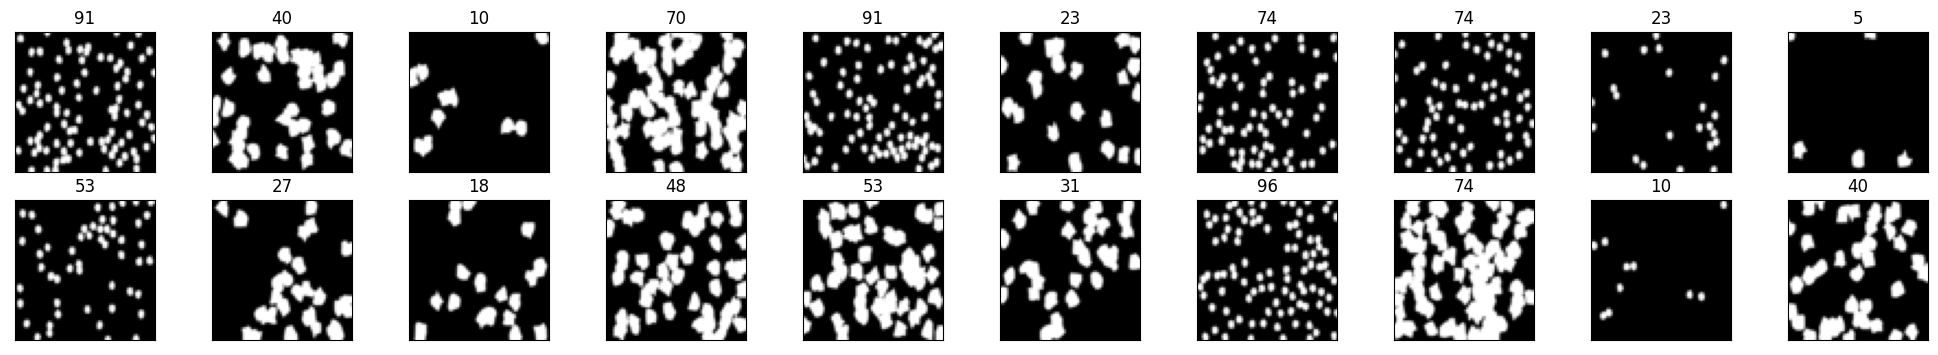

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_loader is defined and ready
dataiter = iter(train_loader)

# Use the built-in next() function to get a batch
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
batch_size = images.shape[0]  # Get the actual batch size
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size // 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # Print out the correct label for each image
    ax.set_title(str(labels[idx].item()))

plt.show()


In [7]:
class ConvLayer(nn.Module):

    def __init__(self, in_channels=1, out_channels=256):
        '''Constructs the ConvLayer with a specified input and output size.
           param in_channels: input depth of an image, default value = 1
           param out_channels: output depth of the convolutional layer, default value = 256
           '''
        super(ConvLayer, self).__init__()

        # defining a convolutional layer of the specified size
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size=9, stride=1, padding=0)

    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input to the layer; an input image
           return: a relu-activated, convolutional layer
           '''
        # applying a ReLu activation to the outputs of the conv layer
        features = F.relu(self.conv(x)) # will have dimensions (batch_size, 20, 20, 256)
        return features

In [8]:
class PrimaryCaps(nn.Module):
      def __init__(self, num_capsules=8, in_channels=256, out_channels=32):
        '''Constructs a list of convolutional layers to be used in
           creating capsule output vectors.
           param num_capsules: number of capsules to create
           param in_channels: input depth of features, default value = 256
           param out_channels: output depth of the convolutional layers, default value = 32
           '''
        super(PrimaryCaps, self).__init__()

        # creating a list of convolutional layers for each capsule I want to create
        # all capsules have a conv layer with the same parameters
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=9, stride=2, padding=0)
            for _ in range(num_capsules)])

      def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; features from a convolutional layer
           return: a set of normalized, capsule output vectors
           '''
        # get batch size of inputs
        batch_size = x.size(0)
        # reshape convolutional layer outputs to be (batch_size, vector_dim=1152, 1)
        u = [capsule(x).view(batch_size, 32 * 6 * 6, 1) for capsule in self.capsules]
        # stack up output vectors, u, one for each capsule
        u = torch.cat(u, dim=-1)
        # squashing the stack of vectors
        u_squash = self.squash(u)
        return u_squash

      def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)
        return output_tensor


In [9]:
import helpers # to get transpose softmax function

# dynamic routing
def dynamic_routing(b_ij, u_hat, squash, routing_iterations=3):
    '''Performs dynamic routing between two capsule layers.
       param b_ij: initial log probabilities that capsule i should be coupled to capsule j
       param u_hat: input, weighted capsule vectors, W u
       param squash: given, normalizing squash function
       param routing_iterations: number of times to update coupling coefficients
       return: v_j, output capsule vectors
       '''
    # update b_ij, c_ij for number of routing iterations
    for iteration in range(routing_iterations):
        # softmax calculation of coupling coefficients, c_ij
        c_ij = F.softmax(b_ij, dim=2)

        # calculating total capsule inputs, s_j = sum(c_ij*u_hat)
        s_j = (c_ij * u_hat).sum(dim=2, keepdim=True)

        # squashing to get a normalized vector output, v_j
        v_j = squash(s_j)
        # if not on the last iteration, calculate agreement and new b_ij
        if iteration < routing_iterations - 1:
            # agreement
            a_ij = (u_hat * v_j).sum(dim=-1, keepdim=True)

            # new b_ij
            b_ij = b_ij + a_ij

    return v_j # return latest v_j

In [3]:
# it will also be relevant, in this model, to see if I can train on gpu
TRAIN_ON_GPU = torch.cuda.is_available()

if(TRAIN_ON_GPU):
    print('Training on GPU!')
else:
    print('Only CPU available')

Only CPU available


In [11]:
class DigitCaps(nn.Module):
    def __init__(self, previous_layer_nodes=32*6*6, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()
        self.W = nn.Parameter(torch.randn(1, previous_layer_nodes, in_channels, out_channels))

    def forward(self, u):
        u = u[None, :, :, None, :]
        W = self.W[:, None, :, :, :]
        u_hat = torch.matmul(u, W)
        b_ij = torch.zeros(*u_hat.size())
        if TRAIN_ON_GPU:
            b_ij = b_ij.cuda()
        # Dynamic routing
        v_j = dynamic_routing(b_ij, u_hat, self.squash, routing_iterations=3)
        return v_j.squeeze(-1).mean(dim=1)  # Retourne un scalaire unique

    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        return scale * input_tensor / torch.sqrt(squared_norm)


In [12]:
class Decoder(nn.Module):

    def __init__(self, input_vector_length=16, input_capsules=10, hidden_dim=512):
        '''Constructs an series of linear layers + activations.
           param input_vector_length: dimension of input capsule vector, default value = 16
           param input_capsules: number of capsules in previous layer, default value = 10
           param hidden_dim: dimensions of hidden layers, default value = 512
           '''
        super(Decoder, self).__init__()

        # calculate input_dim
        input_dim = input_vector_length * input_capsules

        # define linear layers + activations
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # first hidden layer
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2), # second, twice as deep
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim*2, 28*28), # can be reshaped into 28*28 image
            nn.Sigmoid() # sigmoid activation to get output pixel values in a range from 0-1
            )

    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; vectors from the previous DigitCaps layer
           return: two things, reconstructed images and the class scores, y
           '''
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)

        # find the capsule with the maximum vector length
        # here, vector length indicates the probability of a class' existence
        _, max_length_indices = classes.max(dim=1)

        # create a sparse class matrix
        sparse_matrix = torch.eye(10) # 10 is the number of classes
        if TRAIN_ON_GPU:
            sparse_matrix = sparse_matrix.cuda()
        # get the class scores from the "correct" capsule
        y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)

        # create reconstructed pixels
        x = x * y[:, :, None]
        # flatten image into a vector shape (batch_size, vector_dim)
        flattened_x = x.contiguous().view(x.size(0), -1)
        # create reconstructed image vectors
        reconstructions = self.linear_layers(flattened_x)
        # return reconstructions and the class scores, y
        return reconstructions, y

In [13]:
class CapsuleNetwork(nn.Module):
    def __init__(self):
        super(CapsuleNetwork, self).__init__()
        self.conv_layer = ConvLayer(in_channels=1, out_channels=256)  # 1 canal pour niveaux de gris
        self.primary_capsules = PrimaryCaps(num_capsules=8, in_channels=256, out_channels=32)
        self.digit_capsules = DigitCaps(previous_layer_nodes=32*6*6, in_channels=8, out_channels=16)

    def forward(self, images):
        primary_caps_output = self.primary_capsules(self.conv_layer(images))
        caps_output = self.digit_capsules(primary_caps_output).squeeze().mean(dim=-1)  # Réduction scalaire
        return caps_output  # Retourne directement le nombre prédit


In [17]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=9, stride=1, padding=0)

    def forward(self, x):
        features = F.relu(self.conv(x))
        return features

class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=4, in_channels=64, out_channels=16):
        super(PrimaryCaps, self).__init__()
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=9, stride=2, padding=0)
            for _ in range(num_capsules)])

    def forward(self, x):
        batch_size = x.size(0)
        u = [capsule(x) for capsule in self.capsules]  # Liste de tenseurs
        u = torch.cat(u, dim=1)  # Concaténation des canaux, forme: (batch_size, num_capsules * out_channels, h, w)
        u = u.view(batch_size, -1, 1)  # Ajuster le nombre de capsules pour DigitCaps
        return self.squash(u)


    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm)
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)
        return output_tensor

class DigitCaps(nn.Module):
    def __init__(self, previous_layer_nodes, in_channels, out_channels):
        super(DigitCaps, self).__init__()
        self.W = nn.Parameter(torch.randn(1, previous_layer_nodes, in_channels, out_channels))

    def forward(self, u):
        batch_size = u.size(0)
        u = u.view(batch_size, -1, self.W.size(2))  # Ajustez selon votre canal ici
        W = self.W.repeat(batch_size, 1, 1, 1)
        u_hat = torch.matmul(u.unsqueeze(2), W).squeeze(2)  # Correction
        return u_hat  # Ajoutez squash ou routing selon vos besoins

# Assurez-vous que le reste de l'architecture correspond aux ajustements de dimensions ci-dessus

class CapsuleNetwork(nn.Module):
    def __init__(self):
        super(CapsuleNetwork, self).__init__()
        self.conv_layer = ConvLayer(in_channels=1, out_channels=64)
        self.primary_capsules = PrimaryCaps(num_capsules=4, in_channels=64, out_channels=16)
        self.digit_capsules = DigitCaps(previous_layer_nodes=64 * 24 * 24, in_channels=1, out_channels=16)
        self.fc_out = nn.Linear(36864, 1)  # Ajustez le nombre de caractéristiques selon la forme aplatie

    def forward(self, images):
        primary_caps_output = self.primary_capsules(self.conv_layer(images))
        caps_output = self.digit_capsules(primary_caps_output).squeeze().mean(dim=-1)
        
        # Aplatir la sortie
        caps_output = caps_output.view(caps_output.size(0), -1)
        
        regression_output = self.fc_out(caps_output)
        return regression_output


from torchsummary import summary
capsule_net = CapsuleNetwork()

# Affichez un résumé du modèle sur un lot d'images de taille (1, 64, 64)
summary(capsule_net, input_size=(1, 64, 64), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           5,248
         ConvLayer-2           [-1, 64, 56, 56]               0
            Conv2d-3           [-1, 16, 24, 24]          82,960
            Conv2d-4           [-1, 16, 24, 24]          82,960
            Conv2d-5           [-1, 16, 24, 24]          82,960
            Conv2d-6           [-1, 16, 24, 24]          82,960
       PrimaryCaps-7             [-1, 36864, 1]               0
         DigitCaps-8            [-1, 36864, 16]               0
            Linear-9                    [-1, 1]          36,865
Total params: 373,953
Trainable params: 373,953
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 8.13
Params size (MB): 1.43
Estimated Total Size (MB): 9.57
-------------------------------------------

In [36]:
# instantiate and print net
capsule_net = CapsuleNetwork()

print(capsule_net)

# move model to GPU, if available
if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-3): 4 x Conv2d(64, 16, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (fc_out): Linear(in_features=36864, out_features=1, bias=True)
)


In [67]:
import torch.optim as optim

# custom loss
criterion = nn.SmoothL1Loss()

# Adam optimizer with default params
optimizer = optim.Adam(capsule_net.parameters(),lr=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


/home/skan234401/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [74]:
import torch
import os

def train(capsule_net, train_loader, val_loader, criterion, optimizer, n_epochs, print_every=300, device='cuda' if torch.cuda.is_available() else 'cpu'):
    capsule_net.load_state_dict(torch.load('model.pt', map_location=device))
    capsule_net.to(device)  # S'assurer que le modèle est sur l'appareil choisi
    min_val_loss = 4.24909568z # Initialisation de la perte de validation minimale à l'infini

    # Définir le chemin du fichier de sauvegarde dans le même dossier que le script
    save_path = os.path.join(os.getcwd(), 'model.pt')

    for epoch in range(1, n_epochs + 1):
        capsule_net.train()
        train_loss = 0.0

        for batch_i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)  # Déplacez les données sur l'appareil

            optimizer.zero_grad()
            outputs = capsule_net(images)

            loss = criterion(outputs.squeeze(-1), labels.float())  # Taille de outputs : (batch_size,), labels : (batch_size,)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(capsule_net.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

            if batch_i % print_every == 0:
                print(f'Epoch: {epoch} \tBatch: {batch_i} \tLoss: {train_loss / print_every:.8f}')
                train_loss = 0

        # Validation après chaque époque
        val_loss = 0.0
        capsule_net.eval()  # Mode validation
        with torch.no_grad():  # Pas de calcul des gradients pendant l'évaluation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = capsule_net(images)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()

        val_loss /= len(val_loader)  # Moyenne de la perte de validation
        print(f'Epoch: {epoch} \tValidation Loss: {val_loss:.8f}')
        scheduler.step(val_loss)  # Met à jour le taux d'apprentissage en fonction de la validation loss
        
        # Sauvegarde du modèle si la perte de validation est plus petite que la perte minimale précédente
        if val_loss < min_val_loss:
            print(f'Validation Loss a diminué ({min_val_loss:.8f} --> {val_loss:.8f}). Sauvegarde du modèle...')
            min_val_loss = val_loss  # Mettre à jour la perte minimale
            torch.save(capsule_net.state_dict(), save_path)  # Sauvegarder le modèle


In [75]:
# training for 3 epochs
n_epochs = 10
losses = train(capsule_net,train_loader,test_loader, criterion, optimizer, n_epochs=n_epochs)

/tmp/ipykernel_20854/3655701435.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  capsule_net.load_state_dict(torch.load('model.pt', map_location=device))


Epoch: 1 	Batch: 0 	Loss: 0.01670984
Epoch: 1 	Validation Loss: nan
Epoch: 2 	Batch: 0 	Loss: nan


KeyboardInterrupt: 

In [85]:
import torch

def average_absolute_error(model_path,model, data_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  # Passer le modèle en mode évaluation
    total_error = 0.0  # Total des erreurs absolues
    total_samples = 0  # Nombre total d'échantillons

    with torch.no_grad():  # Pas de calcul des gradients
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)  # Envoyer sur le device
            
            outputs = model(images)  # Prédictions du modèle
            
            # Calculer l'erreur absolue
            error = torch.abs(outputs.squeeze() - labels.float())  # Erreur absolue
            total_error += error.sum().item()  # Somme des erreurs
            total_samples += len(images)  # Nombre d'images traitées

    # Calculer l'erreur absolue moyenne
    average_error = total_error / total_samples
    return average_error
average_absolute_error('model.pt',capsule_net,test_loader)

/tmp/ipykernel_20854/1242202719.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


1.5861830314000447

/tmp/ipykernel_20854/1040375159.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


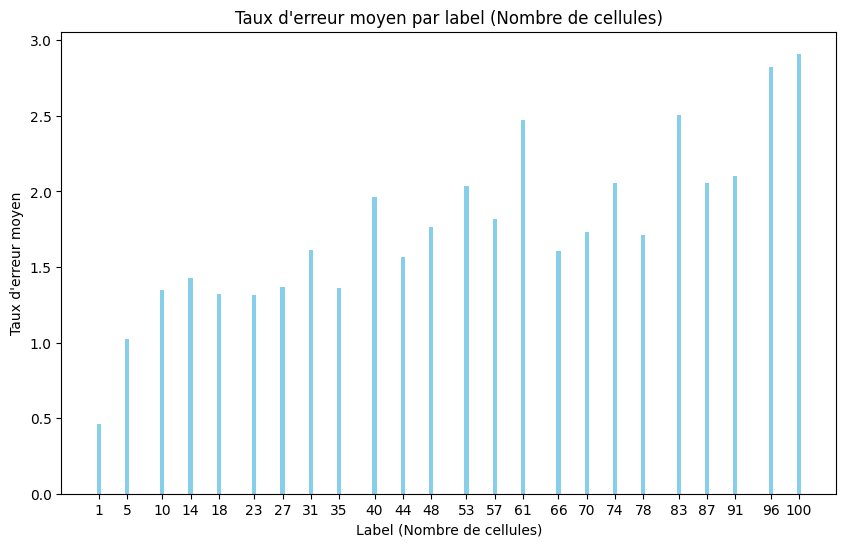

In [86]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_error_rate_by_label(model_path,model, data_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    # Assurez-vous que le modèle est en mode évaluation
    model.eval()

    # Dictionnaire pour stocker les erreurs par label
    errors_by_label = {}

    # Calcul des erreurs pour chaque image
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # Prédiction du modèle
            outputs = model(images)

            # Calcul des erreurs
            errors = torch.abs(outputs.squeeze() - labels.float())  # Erreur absolue entre prédiction et label

            # Enregistrer les erreurs par label
            for label, error in zip(labels.cpu().numpy(), errors.cpu().numpy()):
                if label.item() not in errors_by_label:
                    errors_by_label[label.item()] = []
                errors_by_label[label.item()].append(error)

    # Calcul du taux d'erreur moyen par label
    avg_errors_by_label = {label: np.mean(errors) for label, errors in errors_by_label.items()}

    # Tracer l'histogramme
    labels = list(avg_errors_by_label.keys())
    avg_errors = list(avg_errors_by_label.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, avg_errors, width=0.6, color='skyblue')
    plt.xlabel('Label (Nombre de cellules)')
    plt.ylabel('Taux d\'erreur moyen')
    plt.title('Taux d\'erreur moyen par label (Nombre de cellules)')
    plt.xticks(labels)
    plt.show()

# Exemple d'utilisation avec un modèle et un DataLoader de test
# plot_error_rate_by_label(capsule_net, test_loader)
plot_error_rate_by_label('model.pt',capsule_net,test_loader)

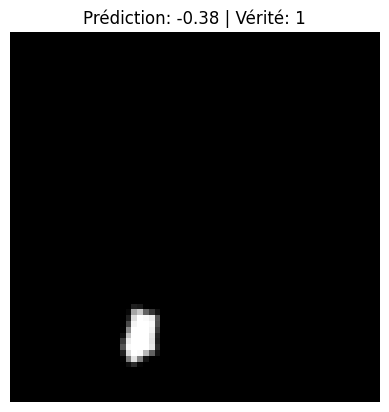

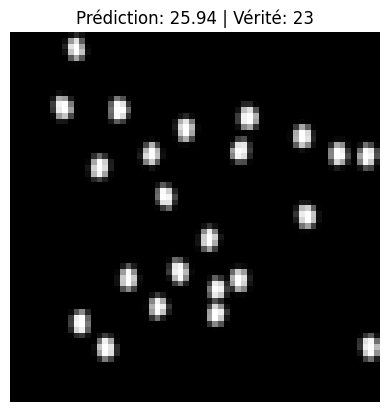

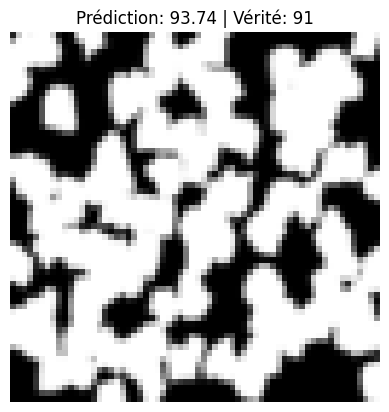

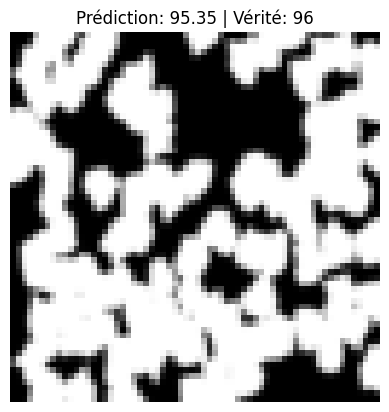

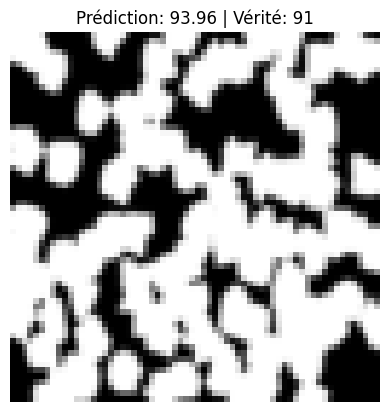

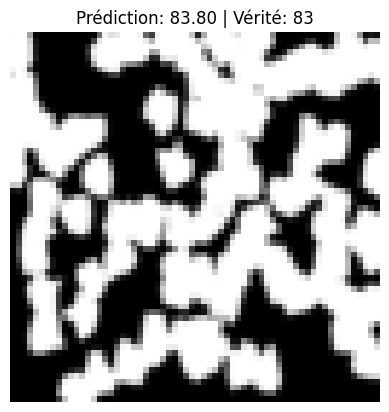

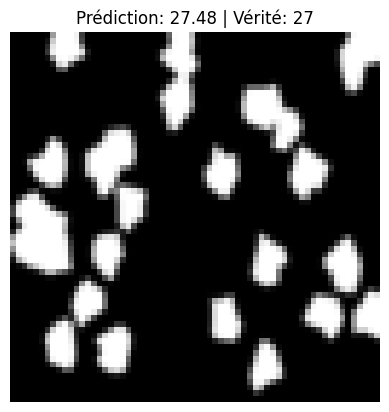

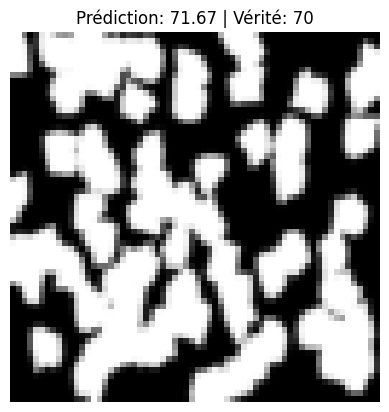

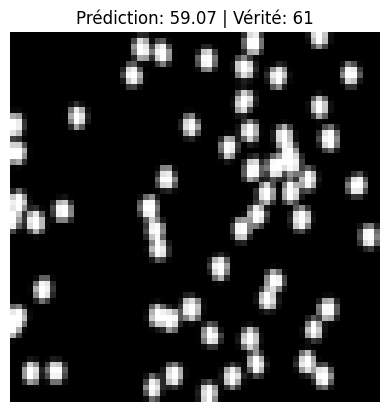

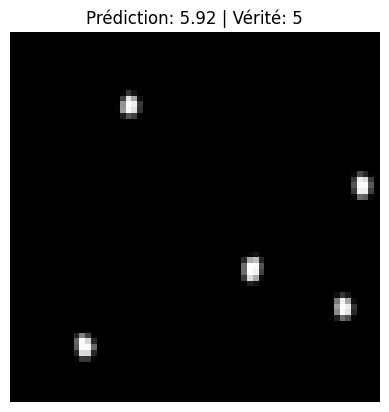

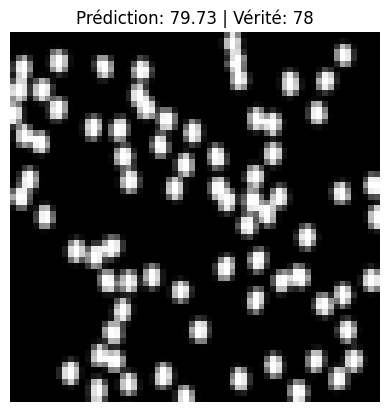

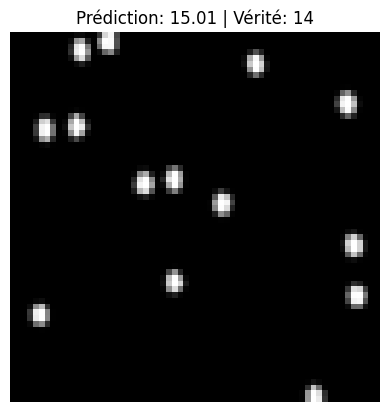

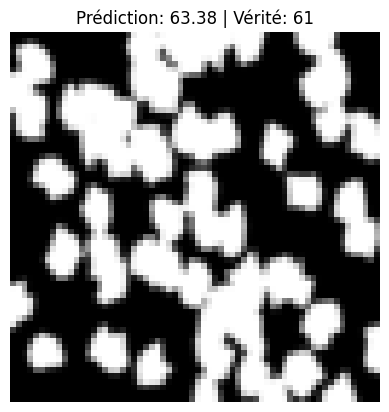

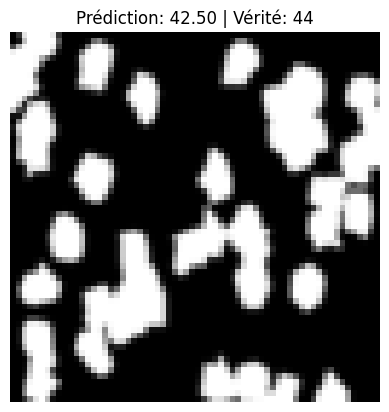

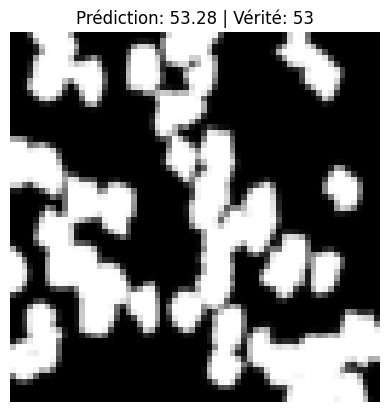

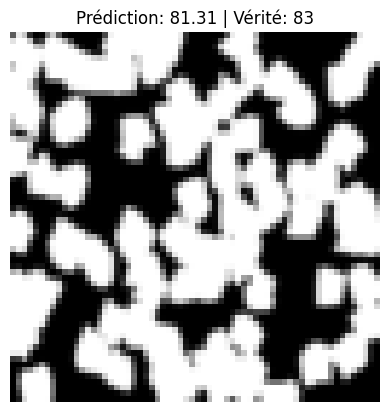

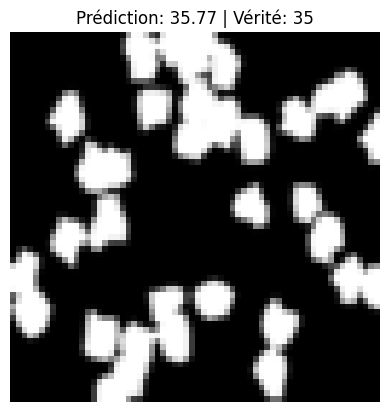

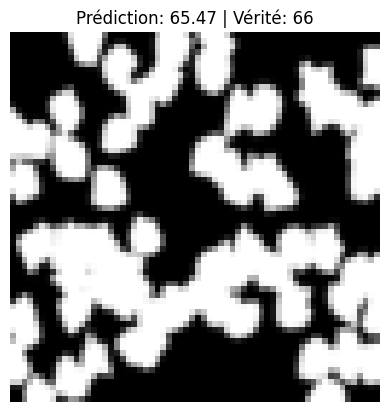

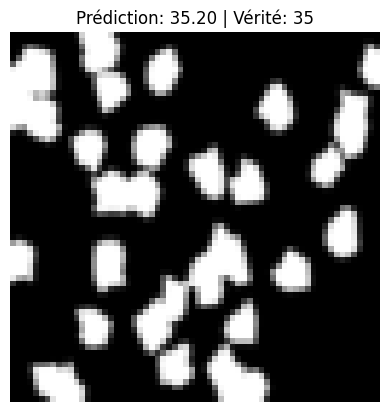

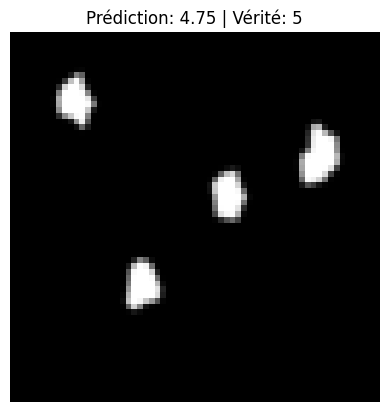

In [83]:
import matplotlib.pyplot as plt
import torch

def show_predictions(model, data_loader, device='cuda' if torch.cuda.is_available() else 'cpu', num_samples=20):
    model.eval()  # Passer le modèle en mode évaluation
    images_shown = 0
    
    with torch.no_grad():  # Pas de calcul des gradients
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Prédictions du modèle
            
            # Afficher les 10 premières prédictions
            for i in range(min(num_samples, len(images))):
                image = images[i].cpu().squeeze().numpy()  # Récupérer l'image (et la convertir en numpy)
                label = labels[i].item()  # Le vrai label
                prediction = outputs[i].item()  # La prédiction du modèle
                
                # Affichage de l'image et des informations
                plt.imshow(image, cmap='gray')
                plt.title(f"Prédiction: {prediction:.2f} | Vérité: {label}")
                plt.axis('off')
                plt.show()
                
                images_shown += 1
                if images_shown >= num_samples:
                    return
show_predictions(capsule_net, train_loader)
